# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year}.tsv``, ``positive_validation_{}_years_after_{}_target_{}.tsv``, ``negative_prediction_upto_{year}.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

In [2]:
target_year = 2010
mid_year = 2011
num_years_later = 0

## Input files
``embedding_SG_dim100_upto{year}.npy`` is the result of word2vec embedding of pubmed. ``words_SG_upto{}.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 195088 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2010.npy and ../data/embeddings_final/words_SG_upto2010.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-2.641621,3.124869,-4.353377,-2.018315,1.823348,-4.975201,-4.787686,2.649930,-2.948251,-0.916163,...,-1.869853,-3.522519,2.618166,-4.450459,-3.961528,-2.892118,-5.928490,0.367299,-4.532290,2.421597
patient,-3.817505,2.731132,-3.133406,-3.360924,3.251447,-3.779796,-4.411118,2.816041,-5.475833,-2.382731,...,-1.941187,-5.431289,2.350188,-5.862311,-3.625207,-4.146669,-4.293906,0.900865,-4.954704,3.698488
meshd009369,-2.000293,2.692290,-3.906482,-2.403826,2.087734,-4.683461,-4.715221,3.363425,-3.719787,-1.557153,...,-1.572250,-5.367291,2.859295,-5.173111,-5.736109,-3.077639,-3.752953,0.597677,-3.388928,4.321077
study,-3.286283,2.197396,-3.055143,-3.488384,1.583849,-3.476388,-4.572982,2.568147,-4.655032,-2.002333,...,-1.750167,-4.790527,2.999226,-5.209653,-4.173866,-6.466439,-4.163732,0.406401,-3.173547,2.894467
1,-1.973735,2.599354,-4.169664,-2.950947,1.642805,-4.464195,-4.122997,3.285105,-3.085233,-2.332377,...,-1.851673,-4.228116,2.728837,-6.189056,-3.837825,-5.297565,-4.471994,0.961740,-3.943491,3.863080
0,-2.586123,2.689704,-4.212170,-3.771425,1.231912,-4.831149,-4.203139,2.516318,-4.278717,-0.870984,...,-1.646774,-3.917393,3.147377,-6.403146,-3.208885,-4.337939,-5.274619,1.493022,-4.262381,3.811445
case,-2.901989,3.094942,-2.662760,-2.999618,3.339018,-4.174236,-3.733308,3.043080,-5.015265,-2.009101,...,-1.629706,-5.274364,2.490766,-6.020258,-4.223149,-5.065413,-4.717482,1.171679,-4.160813,3.578443
2,-1.995389,2.613357,-4.465601,-3.374403,1.476374,-3.963554,-4.275064,3.415569,-3.165894,-2.673264,...,-1.870650,-4.507325,2.781323,-6.268209,-3.587891,-5.258845,-4.164574,0.931996,-4.031983,3.908941
use,-2.350996,2.471157,-3.943660,-4.285838,1.903959,-3.824636,-5.363203,3.795658,-3.144410,-2.605247,...,-1.496192,-3.672382,3.161894,-3.771332,-5.287291,-5.904677,-6.007619,0.785128,-5.524373,3.306188
treatment,-4.137800,2.313303,-4.491300,-4.538378,2.906991,-3.536086,-5.214668,3.688766,-3.349134,-2.446090,...,-1.661259,-3.453831,2.958672,-6.402697,-2.986871,-6.025044,-3.379093,0.627732,-5.395659,5.521724


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  195088


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples = "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd015179,ncbigene1956
1,meshd009362,ncbigene1956
2,meshd016609,ncbigene1956
3,meshd008113,ncbigene1956
4,meshd002289,ncbigene1956


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

161 positive examples
195088 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 132 kinase-cancer difference vectors
[INFO]	Initial data: 161 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 0 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd015179,-1.758768,0.821506,-0.218957,-0.418908,1.173821,2.282200,-0.896008,0.869499,-0.596625,-1.125477,...,0.244606,-0.978184,-0.364866,-0.861954,2.721985,0.355013,-1.774969,0.447741,0.221942,0.967503
ncbigene1956-meshd009362,-0.488660,-0.127344,1.152679,-1.458963,0.629901,1.370382,-0.432642,-0.060593,-0.768857,-0.831967,...,-0.106943,-2.545844,1.020391,2.764358,0.198052,-1.228320,-2.482996,0.121853,-0.002106,-0.983001
ncbigene1956-meshd016609,1.205292,0.113798,-1.177771,-1.224409,-0.320766,0.655336,-1.157197,1.443528,-1.263317,-1.750137,...,0.342476,-3.346388,-0.123938,-0.298214,0.739539,-0.900963,-2.440659,1.079363,0.378580,-1.017632
ncbigene1956-meshd008113,0.243748,0.850496,-0.247731,-1.412440,-1.462184,3.085130,-1.012596,2.120200,-1.968772,-2.174910,...,0.080879,-2.727978,0.043658,-0.467317,0.111648,0.602614,-2.497726,0.504189,-1.959718,0.611904
ncbigene1956-meshd002289,-0.197365,0.567358,-0.211547,0.391760,0.885465,2.867372,0.110631,1.182542,1.366991,-1.176261,...,0.283839,-0.278417,0.089316,0.738022,1.080370,-0.954275,-1.885794,0.135279,-1.811702,-0.210935


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

132 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd000310,ncbigene5578
1,meshd013964,ncbigene50488
2,meshd000069295,ncbigene207
3,meshd008441,ncbigene6355
4,meshd015451,ncbigene23139


In [12]:
print("%d negative examples" % len(negative_df))

1350 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 1171 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 37 gene ids
[INFO]	Could not identify 45 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene5578-meshd000310,1.721813,-0.139020,-0.586205,-1.969351,-2.196893,1.187500,-0.579156,0.488451,0.072510,-0.957250,...,-0.395305,-1.290498,0.521752,1.042413,2.013295,-1.364261,-1.079258,-0.376693,0.178932,0.607813
ncbigene50488-meshd013964,3.746100,-0.936709,2.230587,1.115712,-1.475909,2.252161,1.657704,-0.445074,2.987279,0.938356,...,0.380605,2.517414,-0.913555,5.393040,4.648694,1.360062,1.643937,-0.050030,1.545822,-1.213615
ncbigene6355-meshd008441,0.853830,-1.037516,0.574341,-0.346536,0.219151,0.970842,0.098620,-0.190061,0.050595,0.739297,...,0.258618,1.213816,-1.036368,0.863588,0.335224,0.184446,0.756467,-0.772896,0.767318,0.130367
ncbigene23139-meshd015451,2.831889,-1.213331,0.269525,0.963370,-1.298301,1.595056,1.670335,-0.282978,1.844922,1.335616,...,1.449130,2.139529,-0.934796,2.311158,1.979718,-0.148152,2.120028,-0.642361,1.329516,-0.426924
ncbigene3718-meshd018202,0.451555,-0.322438,-0.755926,-2.468477,1.045336,0.930501,-0.893087,0.695007,-0.687938,-0.498297,...,-0.650762,-0.298184,-0.158255,-0.480634,0.158635,-0.146141,-0.994544,-0.976021,-0.127770,0.329065


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=132) and negative (n=1171) to the combined dataframe (1303)


In [16]:
X_train.values

array([[-1.7587682 ,  0.8215058 , -0.21895671, ...,  0.44774115,
         0.22194195,  0.9675026 ],
       [-0.4886601 , -0.12734413,  1.1526792 , ...,  0.12185264,
        -0.00210643, -0.9830005 ],
       [ 1.2052921 ,  0.11379838, -1.1777706 , ...,  1.0793628 ,
         0.37857962, -1.0176322 ],
       ...,
       [ 0.68350625,  0.5772009 , -0.9531779 , ..., -0.02048043,
         0.00538445,  0.73586345],
       [ 1.6729422 , -0.7972462 ,  1.0951422 , ..., -0.9286587 ,
         2.0605533 , -1.6597056 ],
       [ 1.4850191 , -1.3032411 ,  2.0023508 , ..., -0.22674818,
         1.8580638 , -1.0712987 ]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6020919  0.05149415 0.035237  ]


Text(0, 0.5, 'PC 2 (5.15%)')

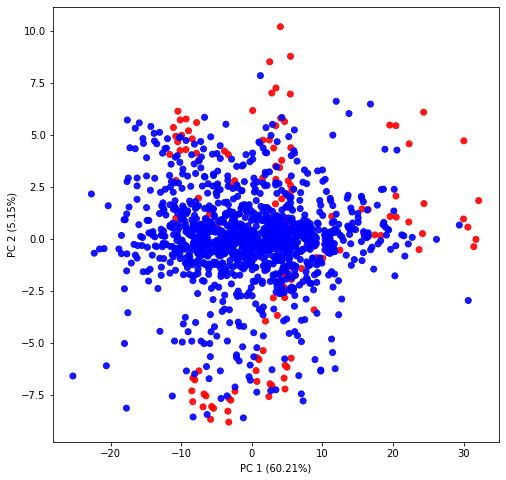

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1303 samples in 0.004s...
[t-SNE] Computed neighbors for 1303 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1303
[t-SNE] Computed conditional probabilities for sample 1303 / 1303
[t-SNE] Mean sigma: 1.173022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.118439
[t-SNE] KL divergence after 300 iterations: 0.756098
t-SNE done! Time elapsed: 2.5992720127105713 seconds


Text(0, 0.5, 'tsne-2d-two')

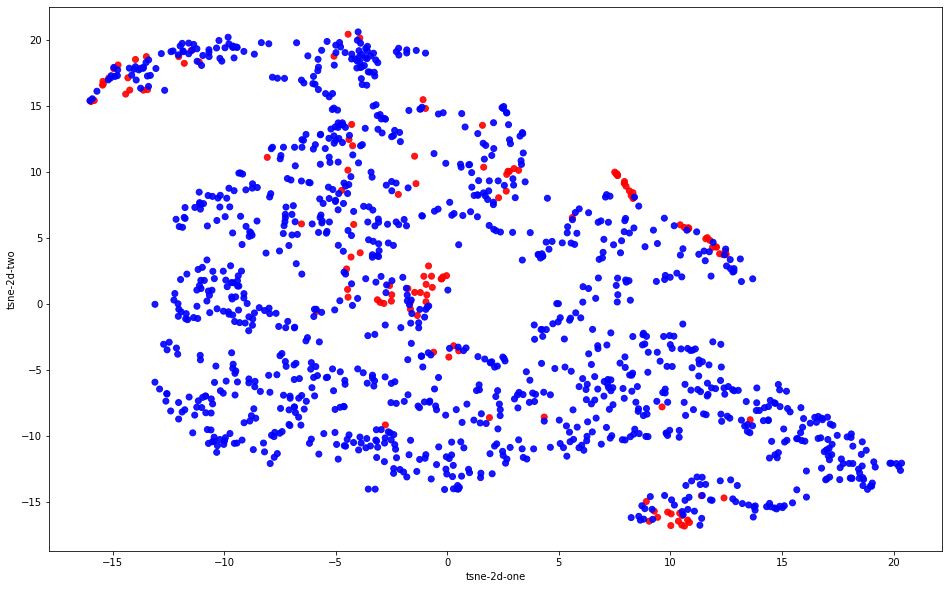

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (1303, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 132, number of negative examples: 1171, Y_train.shape: (1303,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}_target_{}.tsv".format(num_years_later, mid_year,target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd009456,ncbigene4921
1,meshd055752,ncbigene6885
2,meshd018284,ncbigene6885
3,meshd002295,ncbigene55589
4,meshd010673,ncbigene1436


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 309 kinase-cancer difference vectors
[INFO]	Initial data: 356 examples
[INFO]	Could not identify 2 gene ids
[INFO]	Could not identify 9 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene6885-meshd055752,0.968377,-0.468150,-0.036469,-1.430640,0.098031,1.816691,0.314355,0.948098,2.510705,1.712233,...,-0.177926,2.328050,-0.027612,0.569657,1.894871,-0.641782,0.084077,-0.751664,-0.451003,0.876440
ncbigene6885-meshd018284,0.725774,-1.207787,-0.626625,-2.039782,-0.177598,-0.175027,-0.854787,0.582157,2.198111,0.482607,...,-0.189810,0.558733,-0.349440,0.905428,2.075932,-0.108500,0.651377,-1.027773,1.419193,0.358875
ncbigene1436-meshd010673,2.915916,-0.117806,0.159641,0.013395,-0.994384,1.220532,-0.523221,2.004614,0.872296,-0.841455,...,-0.518989,-0.440369,0.058459,1.688404,1.610042,0.619343,-1.663774,-0.273381,0.413893,2.037816
ncbigene6098-meshd002277,0.951803,-1.270585,1.846865,-0.052727,-0.492166,1.876670,0.924562,-2.776580,2.262012,0.207845,...,0.749215,2.933244,-0.847460,2.768583,2.381554,0.792173,1.784118,-0.948483,1.718643,-1.353232
ncbigene4921-meshd009455,1.841703,-1.761460,0.408299,-0.101865,-0.748399,1.236073,-0.165305,-0.947662,-0.509560,0.341705,...,0.097659,0.663505,-0.710407,1.334111,0.298853,1.829006,0.997737,-0.348557,0.957646,-1.354183


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_upto_{}.tsv".format(target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd019574,ncbigene1326
1,meshd000235,ncbigene4915
2,meshd009808,ncbigene84033
3,meshd045888,ncbigene84930
4,meshd000074009,ncbigene8536


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 1159 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 38 gene ids
[INFO]	Could not identify 46 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1326-meshd019574,1.956681,-0.865844,0.660975,-1.501445,0.036164,0.174635,-0.277227,0.965488,0.108881,-0.377339,...,-0.134638,0.857173,-0.378724,0.308366,0.044048,0.563556,0.709227,-1.301858,1.093524,-0.352659
ncbigene4915-meshd000235,-0.491879,-0.304153,-1.246753,-0.618497,-0.747841,0.394957,-1.236726,-0.757592,-0.555422,-0.114012,...,0.112514,0.388359,0.175714,0.267339,-1.853501,-1.355563,-0.900546,-0.921656,-0.188034,0.316561
ncbigene84033-meshd009808,1.010326,-1.339016,0.157419,-0.290503,-1.066116,1.296143,-0.101926,-0.347342,1.368041,0.563565,...,0.783365,0.436986,-1.191390,1.778358,0.634585,1.140238,0.811236,-0.415868,1.447051,-1.586787
ncbigene84930-meshd045888,1.540181,-1.888724,1.053035,0.823246,-0.889372,1.240548,0.914254,-1.807731,1.407184,-0.087058,...,0.158577,1.737434,-0.750413,2.663790,1.873076,1.928143,1.752058,-0.961791,2.541304,-1.879225
ncbigene8536-meshd000074009,1.322850,-1.187474,-0.514278,-1.575048,-0.233855,-0.261673,-0.808019,-0.501783,-0.077858,-0.123412,...,0.063258,0.158258,-0.798082,-0.009637,-0.361907,0.459412,0.274378,-1.572657,0.658215,0.460559


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-target-{}.pkl".format(num_years_later, mid_year,target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path ="positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}.pkl".format(target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)